In [1]:
# set path to compiled vessel module / library
import sys
sys.path.insert(0, '../build/MinGW_Desktop-Release/lib/')
import vessel_module as vs

# for visualization
import pyvista as pv
import numpy as np

In [2]:
def create_tree_mesh(tree : vs.Tree):
    start, end, radius = tree.segment_data()

    tubes = []
    for (s, e, r) in zip(start, end, radius):
        line = pv.PolyData(np.array([s, e]), lines=np.array([2, 0, 1]))
        tubes.append(line.tube(radius=r))

    if len(tubes) == 0:
        return pv.PolyData()

    return tubes[0].merge(tubes[1:])

def plot_vascular_tree(tree : vs.Tree, color = "red"):
    p = pv.Plotter()
    p.add_mesh(create_tree_mesh(tree), color=color)
    p.show_grid(xtitle="x", ytitle="y", ztitle="z")
    p.add_axes()
    p.show(jupyter_backend='static')

def plot_vascular_system(forest : vs.Forest, color = "red"):
    p = pv.Plotter()

    trees = forest.trees()
    for tree in trees:
        p.add_mesh(create_tree_mesh(tree), color=color)
    p.show_grid(xtitle="x", ytitle="y", ztitle="z")
    p.add_axes()
    p.show(jupyter_backend='static')

## Example: Grow Arterial Tree in Sphere

In [3]:
# define domain in which vessels should grow; can be = DomainCircle, DomainSphere, DomainLines, DomainVoxels
# -> boundaries are not strictly enforced; it just defines locations of samples for attraction points
sphere = vs.DomainSphere([0.0, 0, 0], 0.5)

# create synthesizer object for domain
synth = vs.Synthesizer(sphere)

# modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
synth.settings.steps = 35
synth.settings.scale(1.5)

# set root note of tree (or use set_forest(...)) to grow from intial trees
synth.create_root(vs.System.ARTERIAL, [0.5, 0.0, 0.0])
synth.run()

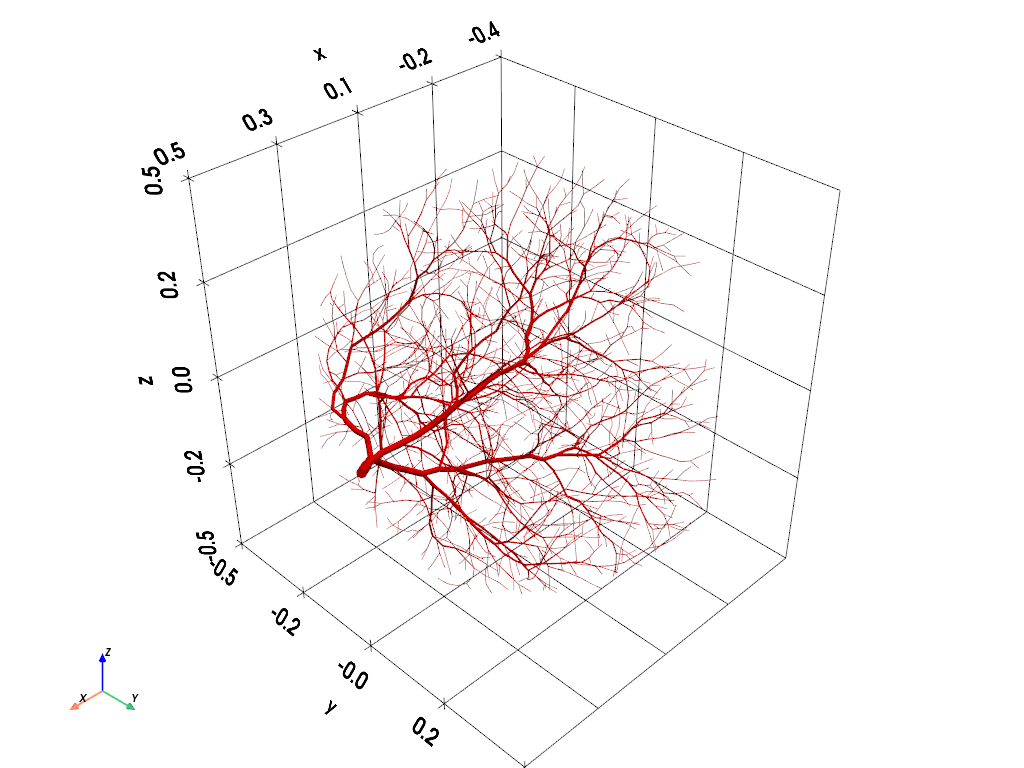

In [4]:
# get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
forest = synth.get_arterial_forest()

# show developed vascular structure
plot_vascular_system(forest, "red")

## Example: Voxel Domain

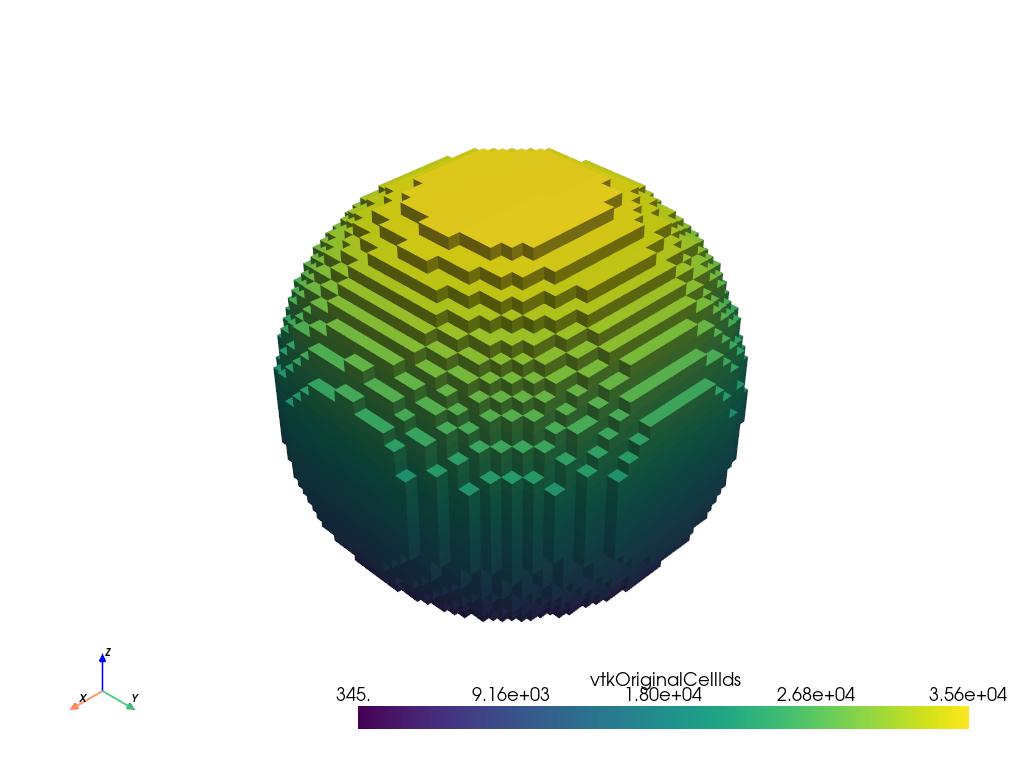

In [5]:
from pyvista import examples

density = 0.03
mesh = pv.voxelize(pv.Sphere(center=[0., 0.0, 0.0]), density=density)
mesh.plot(scalars='vtkOriginalCellIds', jupyter_backend='static')

x_min, x_max, y_min, y_max, z_min, z_max = mesh.bounds
x = np.arange(x_min, x_max, density)
y = np.arange(y_min, y_max, density)
z = np.arange(z_min, z_max, density)

In [6]:
# voxel domain can be initialized from voxel centers
voxels = vs.DomainVoxels([x_min, y_min, z_min], [x_max, y_max, z_max], [x.size, y.size, z.size], mesh.cell_centers().points)

In [7]:
# or voxels from a bit mask (bool)

x_, y_, z_ = np.meshgrid(x, y, z)
grid = pv.StructuredGrid(x_, y_, z_ )
ugrid = pv.UnstructuredGrid(grid)

# get part of the mesh within the mesh's bounding surface.
selection = ugrid.select_enclosed_points(mesh.extract_surface(),
                                         tolerance=0.0,
                                         check_surface=False)

mask = selection.point_data['SelectedPoints'].view(bool)

voxels = vs.DomainVoxels([x_min, y_min, z_min], [x_max, y_max, z_max], [x.size, y.size, z.size], mask.flatten(order="F"))

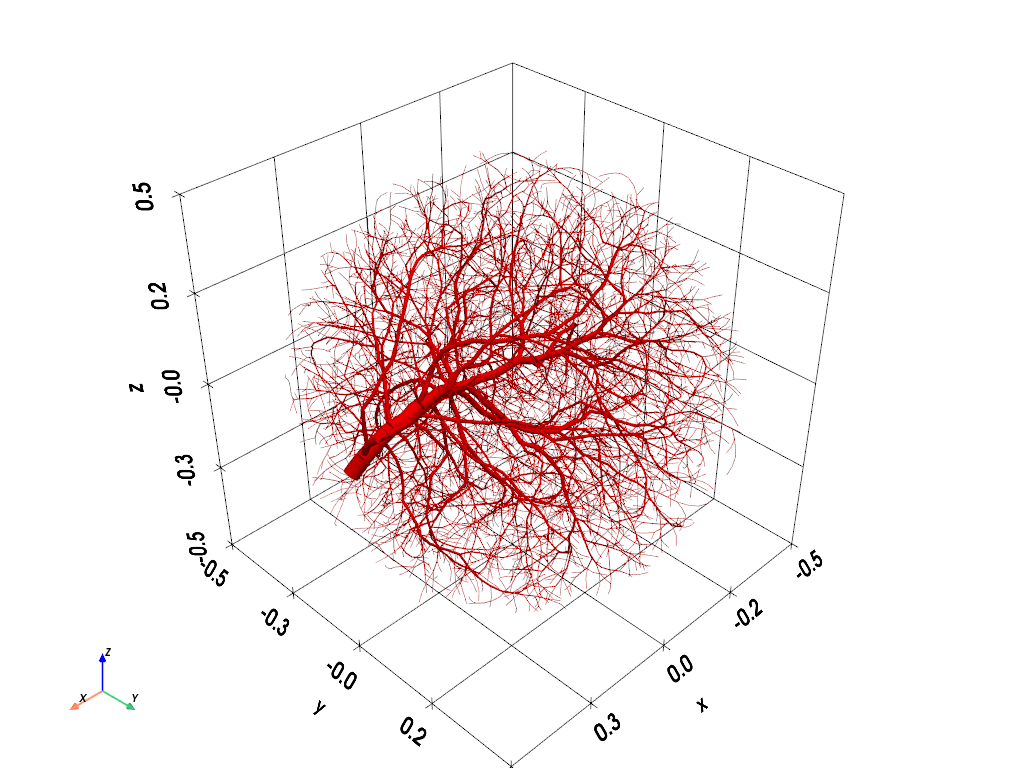

In [8]:
# create synthesizer object for domain
synth = vs.Synthesizer(voxels)

# modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
synth.settings.steps = 100
synth.settings.samples = 1000
synth.settings.scale(1.5)

# set root note of tree (or use set_forest(...)) to grow from intial trees
synth.create_root(vs.System.ARTERIAL, [0.49, 0.0, 0.0])
synth.run()

plot_vascular_system(synth.get_arterial_forest(), "red")

## Performance Monitoring

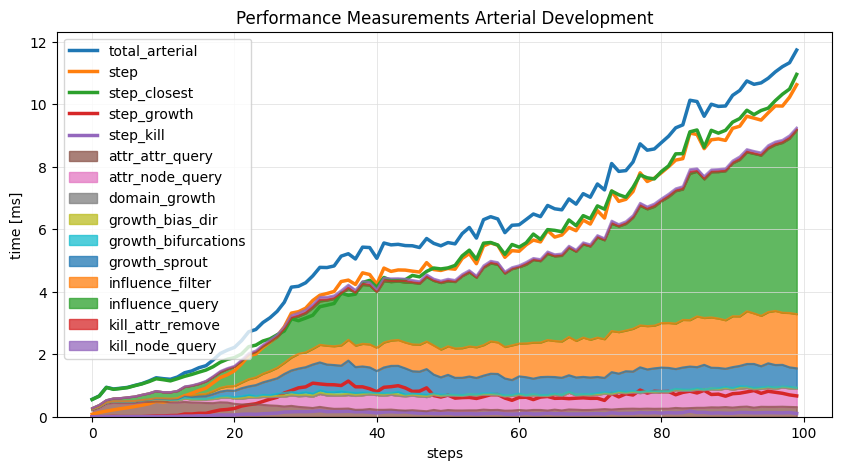

In [9]:
# check if library was compiled with performance monitor
if vs.PerfMonitor.Enabled:
    import pandas as pd
    import matplotlib.pyplot as plt

    # retrieve time measurements as dictonary
    times = synth.get_arterial_perftimes()

    # create pandas dataframe
    df = pd.DataFrame.from_dict(times)
    df = df.astype("timedelta64[ns]").astype("int64")
    df = df / 1e+6;

    # plot
    fig, ax = plt.subplots(figsize=(10,5))
    df[["total_arterial", "step", "step_closest", "step_growth", "step_kill"]].plot(ax = ax, kind="line", lw=2.5)
    df[df.columns.difference(["total_arterial", "step", "step_closest", "step_growth", "step_kill"])].plot(ax = ax, kind="area", stacked=True, alpha=0.75)

    ax.set_title("Performance Measurements Arterial Development")
    ax.set_xlabel("steps")
    ax.set_ylabel("time [ms]")
    ax.grid(which='major', color='#DDDDDD', linewidth=0.5)

## Tree Iteration and Pruning

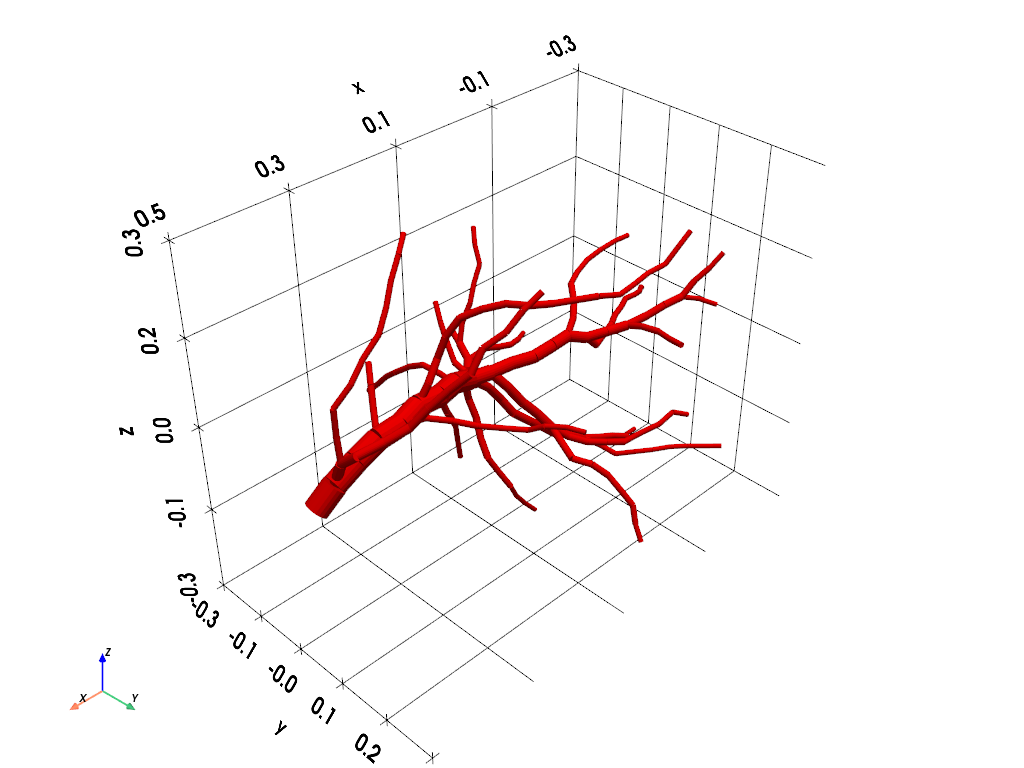

In [10]:
# get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
forest = synth.get_arterial_forest()

# get reference to tree by [] operator
tree = forest[0]

# iteration functions to iterate topology (see python_bindings.cpp for node attributes -> node.position, node.radius, node.parent (id), node.children (id, id))
tree.breadth_first(lambda node : None)
tree.depth_first(lambda node : None)
tree.post_order(lambda node : None)

# collect segment data i-th entry is start-end position and radius connecting two points in the tree
start, end, radius = tree.segment_data()

# delete nodes (and alls conncention down-stream) based on some criterion
tree.delete_if(lambda node : True if node.radius < 0.004 else False)

plot_vascular_tree(tree, "red")

## Grow from initial tree

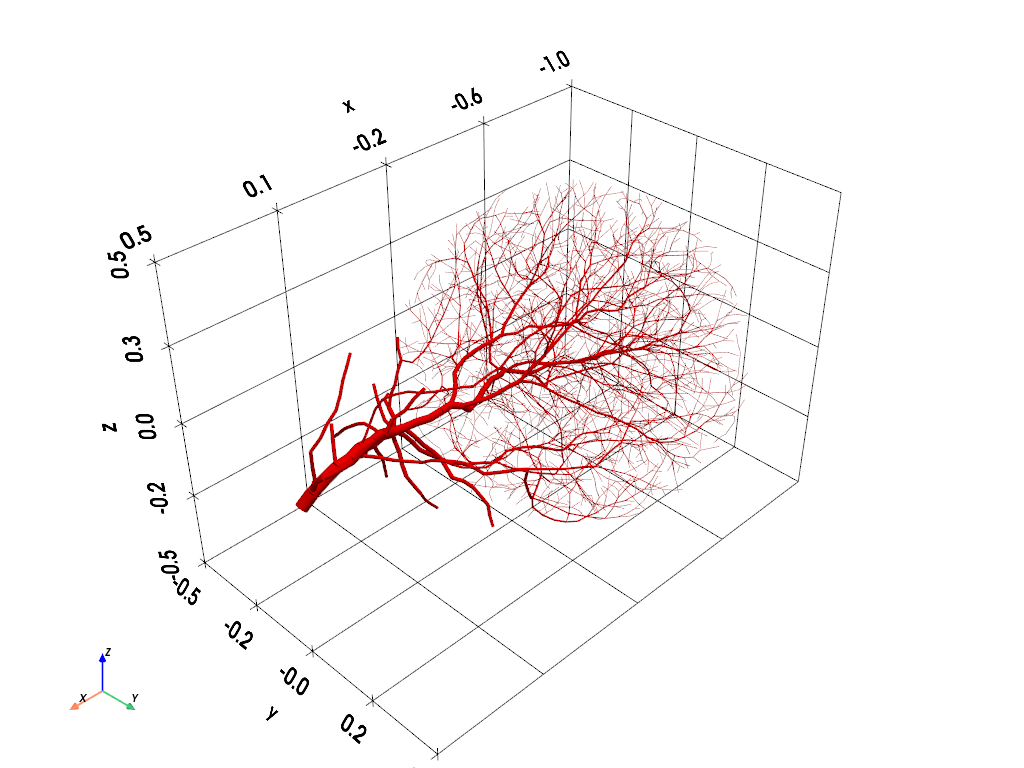

In [11]:
sphere = vs.DomainSphere([-0.5, 0.0, 0.0], 0.5)

synth = vs.Synthesizer(sphere)

# modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
synth.settings.steps = 35
synth.settings.samples = 2000
synth.settings.scale(1.5)

# set root note of tree (or use set_forest(...)) to grow from intial trees
synth.set_arterial_forest(forest)
synth.run()

plot_vascular_system(synth.get_arterial_forest(), "red")